## NHL Season Playoff Outcome Logistic Regression

### Description

The following classification analysis seeks to predict failed playoff outcomes with team season adjusted wins (wins + (ties / 2)) above the avgerage adjusted wins of any given season for years 1983 - 2021.

The goal of the analysis is to build a model that can use aboveAvgAdjWins to predict playoff outcomes.

By understanding the mentioned features above, a clearer understanding of the path to **not making** versus **making** the playoffs should be gained. 

In [1]:
# Import libraries
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from Preprocessing_Functions import *
from Classification_Metrics_Functions import *

from pickle import dump 
from pickle import load

c:\Users\jbenvenuto\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\jbenvenuto\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\Users\jbenvenuto\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


### Data Preprocessing

In [2]:
# Import the data frame from the logistic regression EDA
nhl_df = pd.read_csv('Data/NHL_1983_2021_Playoff_Data_Removed_Outliers.csv')

# Print Data Summary
nhl_df.info()
nhl_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   aboveAvgAdjWins  922 non-null    float64
 1   missed_playoffs  922 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 14.5 KB


,aboveAvgAdjWins,missed_playoffs
0,-19.470588,1
1,12.029412,0
2,6.529412,0
3,9.029412,0
4,-20.970588,1


The data from the logistic regression EDA analysis is imported.

In [3]:
# Check the frequency of missed_playoffs
failed_playoff_flag_strata = nhl_df['missed_playoffs'].value_counts() / len(nhl_df)
print(failed_playoff_flag_strata)

0    0.583514
1    0.416486
Name: missed_playoffs, dtype: float64


The frequencies of the missed_playoffs instances are observed.

In [4]:
# Split the data into an 80/20 train and test stratified split by missed_playoffs frequency
split = StratifiedShuffleSplit(
    n_splits = 1, 
    test_size = 0.2, 
    random_state = 42
) 

for train_index, test_index in split.split(nhl_df, nhl_df['missed_playoffs']):
    strat_train_set = nhl_df.loc[train_index] 
    strat_test_set = nhl_df.loc[test_index]

The data is at an 80/20 stratified train and test split. This will allow the train and test data to retain the proportion of playoff outcomes (missed_playoffs).

Splitting the data through stratified splits will allow for a more robust model.


train and test data season type percent of data:


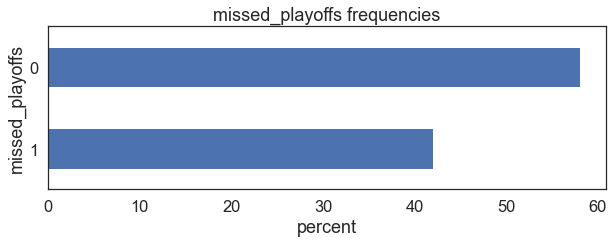

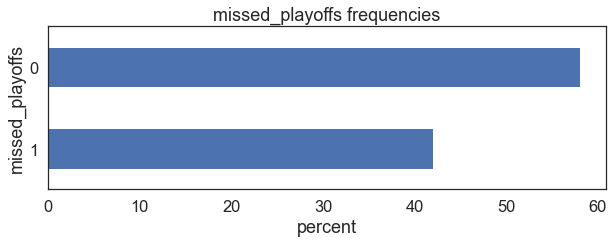

In [5]:
# Check the train and test data missed_playoffs frequency to test the stratified data split
print('\n' + 'train and test data season type percent of data:')

train_temp = strat_train_set[['missed_playoffs']].astype(str)
test_temp = strat_test_set[['missed_playoffs']].astype(str)

cat_univariate_freq(
    df = train_temp, 
    length = 3, 
    width = 10, 
    col_start = 0, 
    col_end = 1, 
    font = 1.5
)

cat_univariate_freq(
    df = test_temp, 
    length = 3, 
    width = 10, 
    col_start = 0, 
    col_end = 1, 
    font = 1.5
)

The stratified train and test split playoff outcome proportions are visualized through the missed_playoffs for train and test data.

We can see that it is more likely for teams to make the playoffs than miss out through the visualization. Creating this model should help narrow the focus on why teams miss the playoffs and avoid this path when organizing their future or current campaigns.

In [6]:
# Slpit the train set into X_train and y_train
X_train = strat_train_set[strat_train_set.columns[0:len(strat_train_set.columns)-1]].reset_index(drop = True)
y_train = strat_train_set[['missed_playoffs']].reset_index(drop = True)

print('\n','<------------------------------------ Train Data ------------------------------------>'.center(110),'\n')
print(X_train.info())
display(X_train.head())
print(y_train.info())
display(y_train.head())

# Slpit the test set into X_test and y_test
X_test = strat_test_set[strat_test_set.columns[0:len(strat_test_set.columns)-1]].reset_index(drop = True)
y_test = strat_test_set[['missed_playoffs']].reset_index(drop = True)

print('\n','<------------------------------------ Test Data ------------------------------------>'.center(110),'\n')
print(X_test.info())
display(X_test.head())
print(y_test.info())
display(y_test.head())


             <------------------------------------ Train Data ------------------------------------>             

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   aboveAvgAdjWins  737 non-null    float64
dtypes: float64(1)
memory usage: 5.9 KB
None


,aboveAvgAdjWins
0,-11.852941
1,1.183333
2,-6.316667
3,-6.645161
4,1.571429


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   missed_playoffs  737 non-null    int64
dtypes: int64(1)
memory usage: 5.9 KB
None


,missed_playoffs
0,1
1,0
2,1
3,1
4,0



             <------------------------------------ Test Data ------------------------------------>              

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   aboveAvgAdjWins  185 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB
None


,aboveAvgAdjWins
0,-8.865385
1,14.571429
2,4.416667
3,1.147059
4,1.441176


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   missed_playoffs  185 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB
None


,missed_playoffs
0,1
1,0
2,0
3,0
4,0


The train and test data are split so X and y values are set to their own data frames.

In [7]:
k_fold = StratifiedShuffleSplit(
    n_splits = 10, 
    random_state = 0, 
    test_size = 0.20, 
    train_size = None
)

print('\n' + 'Train and Test Shuffled K-Fold Data:' + '\n')
for train_index, test_index in k_fold.split(X_train,  y_train['missed_playoffs']):
    print("train index:", train_index[:10], "length:", len(train_index))
    print("test index:", test_index[:10], "length:", len(test_index))
    print('')


Train and Test Shuffled K-Fold Data:

train index: [696 113 639 192 628  53 174 112 256 583] length: 589
test index: [228 441 665 251 352 421 294 219 158  79] length: 148

train index: [655 487  70 400 542 401 430 450 513 346] length: 589
test index: [677  63 564 414 246 396 455 534  77 633] length: 148

train index: [107 605 149 482 557 235 383 137 420 307] length: 589
test index: [736 448 198 244 121 709 316 591 533 654] length: 148

train index: [ 22  20  33 636 393 436 640 150 386 139] length: 589
test index: [608 288 542 373 122 204 631 238 237 676] length: 148

train index: [331 461 406 116 451 115 589 304 562 311] length: 589
test index: [163 292 312 185 593 520 713 543 393 367] length: 148

train index: [ 67 605  30 527 250 584 187 633 255 212] length: 589
test index: [ 71 640 617 387 229  98 562  51 119 397] length: 148

train index: [286 707 336 372 179  65   3  18 107 616] length: 589
test index: [ 47 469 175 514 523 240 252 577 384  17] length: 148

train index: [ 88 550  

In [8]:
# GridSearchCv for hyper paramters
penalty = [
    'l1', 
    'l2',
    'elasticnet',  
    'None'
]

C = np.geomspace(
    start = 10,
    stop = 100, 
    num = 10
)

solver = ['liblinear', 'lbfgs']

params = {
    'penalty': penalty,
    'C': C,
    'solver': solver
}

grid = GridSearchCV(
    LogisticRegression(), 
    params, 
    cv = k_fold, 
    scoring = 'f1'
)

grid.fit(X_train, y_train)
grid.best_score_, grid.best_params_

(0.8576594178406138, {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'})


test model f-fold metrics:



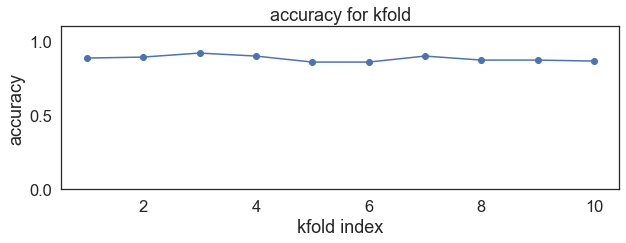

accuracy k-fold cross validation:                  ................0.88
accuracy std:                                      ................0.02


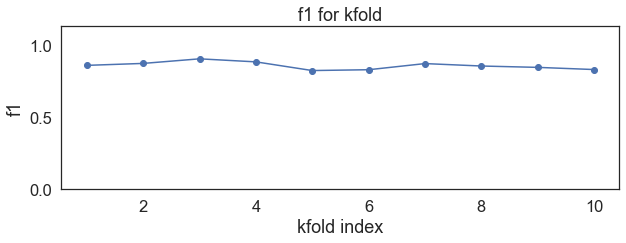



f1 k-fold cross validation:                        ................0.86
f1 std:                                            ................0.02


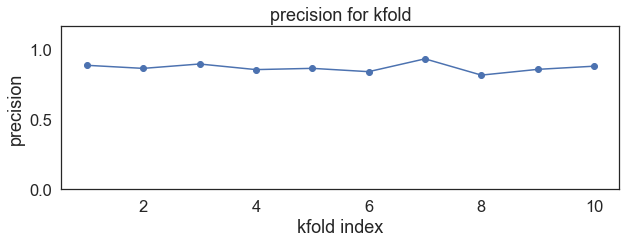



precision k-fold cross validation:                 ................0.86
precision std:                                     ................0.03


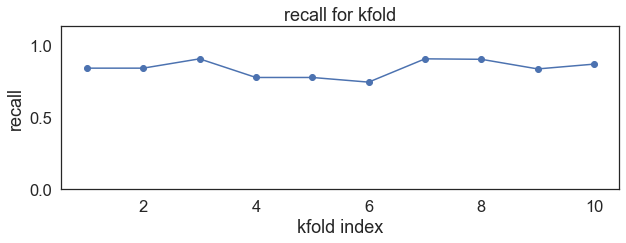



recall k-fold cross validation:                    ................0.84
recall std:                                        ................0.06




In [9]:
# Test metrics across the k-folds
logit_regressor = LogisticRegression(
    penalty = grid.best_params_.get('penalty'),
    C = grid.best_params_.get('C'),
    solver = grid.best_params_.get('solver')
)

classification_cross_val_splits(
    classifier = logit_regressor, 
    X_train = X_train, 
    y_train = y_train, 
    cv = k_fold,
    font = 1.5
)

Above are the k-fold cross validation results.

The model performance appears to deliver strong and consistent results on the train data. 

### Model Training and Testing

#### Model Training, Evaluation, and Interpretation

In [10]:
# Fit and train the logistic regression model
logit_regressor = LogisticRegression()
logit_regressor.fit(X_train,  y_train)

# Predict with X_train data
y_pred_train = logit_regressor.predict(X_train)

# Create a data frame from the predicted results
y_pred_train = pd.DataFrame(y_pred_train, columns = ['predictions_train'])

# Creates a data frame from the prediction probabilities
proba = logit_regressor.predict_proba(X_train)
proba = pd.DataFrame(proba, columns = ['0', 'predicted_proba'])

proba = proba[['predicted_proba']]

# Create a separate data frame from y_train
playoff_flag = y_train.reset_index(drop = True).reset_index(drop = True)

# Concatenate all three data frames
data_frames = [
    playoff_flag, 
    y_pred_train, 
    proba
]

results = pd.concat(data_frames, axis = 1)

# Print data summary
print('\n')
results.info()
display(results.head())

# Observe features for significance
print('\n')
logit_summary(X = X_train, y = y_train)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   missed_playoffs    737 non-null    int64  
 1   predictions_train  737 non-null    int64  
 2   predicted_proba    737 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 17.4 KB


,missed_playoffs,predictions_train,predicted_proba
0,1,1,0.991259
1,0,0,0.232907
2,1,1,0.901642
3,1,1,0.914108
4,0,0,0.202895




Optimization terminated successfully.
         Current function value: 0.309078
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.545      
Dependent Variable: missed_playoffs  AIC:              459.5808   
Date:               2022-05-29 17:50 BIC:              468.7859   
No. Observations:   737              Log-Likelihood:   -227.79    
Df Model:           1                LL-Null:          -500.54    
Df Residuals:       735              LLR p-value:      1.2029e-120
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
const             -0.6548   0.1226  -5.3394 0.0000 -0.8952 -0.4144
aboveAvgAdjWins   -0.4549   0.0336 -13.5541 0.0000 -0.5206 -0.3891
==================================================================

"""

The model is trained to predict missed_playoffs output by the aboveAvgAdjWins. 

In [11]:
# Adjust prediction threshold
proba_threshold = 0.386778

results['predictions_train'] = np.where(
    results['predicted_proba'] >= proba_threshold,
    1, 0
)

# Print data summary
print('\n')
results.info()
results.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   missed_playoffs    737 non-null    int64  
 1   predictions_train  737 non-null    int32  
 2   predicted_proba    737 non-null    float64
dtypes: float64(1), int32(1), int64(1)
memory usage: 14.5 KB


,missed_playoffs,predictions_train,predicted_proba
0,1,1,0.991259
1,0,0,0.232907
2,1,1,0.901642
3,1,1,0.914108
4,0,0,0.202895




Pairs:                              ..............132010
Conc:                               ..............124364
Disc:                               ................7629
Tied:                               ..................17


Concordance:                        ................0.94
Discordance:                        ................0.06
Tied:                               .................0.0


AUC:                                ................0.94




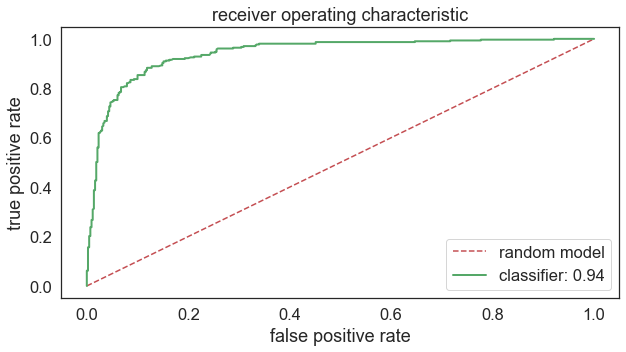



confussion matrix:



,1,0
1,273,57
0,34,373




Accuracy:                                                                   ................0.88
Precision (tp / (tp + fp)):                                                 ................0.83
Recall (tp / (tp + fn)):                                                    ................0.89
F1 ((2 * (precision * recall)) / (precision + recall)):                     ................0.86
False Positive Rate (fp / (fp + tn))                                        ................0.13
True Positive Rate ((tp / (tp + fn)):                                       ................0.89
Increase in TPR / FPR (true_positive_rate / false_positive_rate):           ................6.85




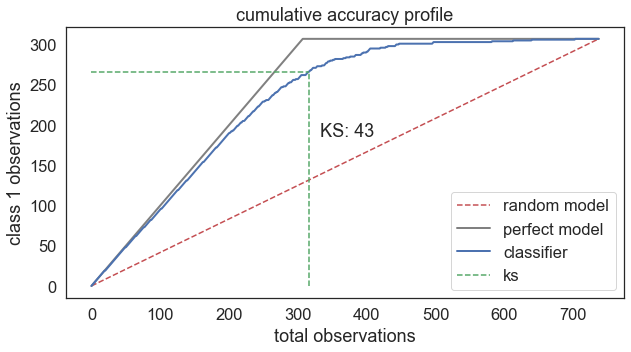

,bin,count_of_rows,missed_playoffs,model_percent,random_percent,model_cumm_percent,random_cumm_percent,ks
0,0.0,0,0,0.00,0,0.00,0,0.00
1,1.0,74,71,23.13,10,23.13,10,13.13
2,2.0,74,69,22.48,10,45.61,20,25.61
3,3.0,74,65,21.17,10,66.78,30,36.78
4,4.0,74,51,16.61,10,83.39,40,43.39
5,5.0,74,27,8.79,10,92.18,50,42.18
6,6.0,74,17,5.54,10,97.72,60,37.72
7,7.0,74,3,0.98,10,98.70,70,28.70
8,8.0,74,1,0.33,10,99.03,80,19.03
9,9.0,74,2,0.65,10,99.68,90,9.68


,bin,min_predicted_proba_per_bin,max_predicted_proba_per_bin,mean_predicted_proba_per_bin,median_predicted_proba_per_bin
0,1.0,0.980263,0.999974,0.992777,0.995055
1,2.0,0.911876,0.978762,0.947411,0.949804
2,3.0,0.747877,0.911876,0.837610,0.846483
3,4.0,0.523268,0.742776,0.622175,0.606333
4,5.0,0.269138,0.518147,0.386778,0.380589
5,6.0,0.139118,0.269138,0.201840,0.201699
6,7.0,0.061150,0.138206,0.095793,0.093391
7,8.0,0.026822,0.061150,0.044203,0.043057
8,9.0,0.008520,0.026611,0.016741,0.015869
9,10.0,0.000073,0.008293,0.003459,0.003411


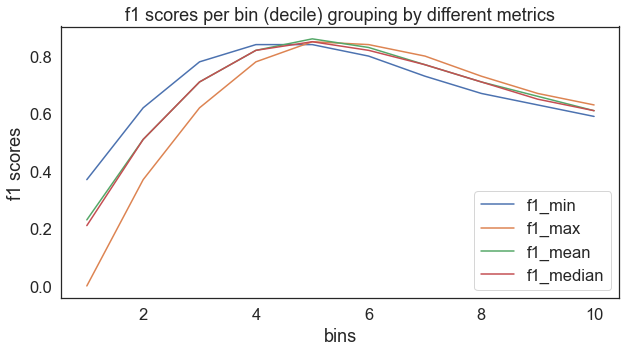

,bin,threshold_min,f1_min,threshold_max,f1_max,threshold_mean,f1_mean,theshold_median,f1_median
0,1.0,0.980263,0.37,0.999974,0.00,0.992777,0.23,0.995055,0.21
1,2.0,0.911876,0.62,0.978762,0.37,0.947411,0.51,0.949804,0.51
2,3.0,0.747877,0.78,0.911876,0.62,0.837610,0.71,0.846483,0.71
3,4.0,0.523268,0.84,0.742776,0.78,0.622175,0.82,0.606333,0.82
4,5.0,0.269138,0.84,0.518147,0.85,0.386778,0.86,0.380589,0.85
5,6.0,0.139118,0.80,0.269138,0.84,0.201840,0.83,0.201699,0.82
6,7.0,0.061150,0.73,0.138206,0.80,0.095793,0.77,0.093391,0.77
7,8.0,0.026822,0.67,0.061150,0.73,0.044203,0.71,0.043057,0.71
8,9.0,0.008520,0.63,0.026611,0.67,0.016741,0.66,0.015869,0.65
9,10.0,0.000073,0.59,0.008293,0.63,0.003459,0.61,0.003411,0.61


In [12]:
# Train results
train_cap_auc = cap_auc(
    model = logit_regressor, 
    df = results, 
    target = 'missed_playoffs', 
    y = playoff_flag, 
    y_pred = results[['predictions_train']], 
    y_score = proba, 
    X = X_train, 
    length = 5, 
    width = 10, 
    ks = 43,
    text = 'KS: 43',
    font = 1.5
)

display(train_cap_auc)
print('\n')

# Bootstrap f1 results
boostrap_f1(
    cap_threshold_df = train_cap_auc,
    x_axis = 'bin',
    results_df = results, 
    real_results_col = 'missed_playoffs', 
    pred_col = 'predictions_train', 
    pred_proba_col = 'predicted_proba',
    length = 5,
    width = 10,
    font = 1.5
)

The train model shows strong results. 

Notable observations:

1) **Concordance - 0.94** - The model probability thresholds are functioning efficiently. For every pair of positive and negative predictions, 95% of the time, positive predictions have higher probabilities than negative predictions.<br><br>

2) **Area Under the Curve (AUC) 0.94** - Being similar to **Concordance**, AUC is Concordance + (tied output pairs * 0.5). Because the model contains no tied pairs when calculating Concordance, AUC comes out to the same value. There is a 94% chance that the model will be able to distinguish between 1 and 0.<br><br>

3) **F1 - 0.85** - This shows that the model is working to make predictions based on the variance of predictors. The model is not making predictions full of positives and false positives or negatives and false negatives to attain high accuracy. F1 (harmonic mean of precision and recall) describes that out of all positives predicted, 0.86 are correct (precision), and out of all positive outcomes in the data, 0.84 were predicted by the model correct (recall).<br><br>

4) **Kolmogorov-Smirnov Measure (ks)** - shows that the model predicts 84% of the data's true positives in the first four deciles of the data. The difference between the model and what a random model predicts is ks (84% - 40% = 44%). To rephrase, the model improves prediction from the random base by 2.1 times, peaking at the 4th decile of the data displaying the model's efficiency in filtering for true positive predictions.<br><br>

#### Model Testing, Evaluation, and Interpretation

In [13]:
# Predict with X_test data
y_pred_test = logit_regressor.predict(X_test)

# Create a data frame from the predicted results
y_pred_test = pd.DataFrame(y_pred_test, columns = ['predictions_test'])

# Creates a data frame from the prediction probabilities
proba = logit_regressor.predict_proba(X_test)

proba = pd.DataFrame(proba, columns = ['0', 'predicted_proba'])

proba = proba[['predicted_proba']]

# Create a separate data frame from y_test
playoff_flag = y_test.reset_index(drop = True).reset_index(drop = True)

# Concatenate all three data frames
data_frames = [
    playoff_flag, 
    y_pred_test, 
    proba
]

results = pd.concat(data_frames, axis = 1)

# Print data summary
print('\n')
results.info()
results.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   missed_playoffs   185 non-null    int64  
 1   predictions_test  185 non-null    int64  
 2   predicted_proba   185 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 4.5 KB


,missed_playoffs,predictions_test,predicted_proba
0,1,1,0.966869
1,0,0,0.000692
2,0,0,0.065314
3,0,0,0.235865
4,0,0,0.212635


Using the test data, the model is used to predict the missed_playoffs output by aboveAvgAdjWins.

In [14]:
# Adjust prediction threshold
results['predictions_test'] = np.where(
    results['predicted_proba'] >= proba_threshold,
    1, 0
)

# Print data summary
print('\n')
results.info()
results.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   missed_playoffs   185 non-null    int64  
 1   predictions_test  185 non-null    int32  
 2   predicted_proba   185 non-null    float64
dtypes: float64(1), int32(1), int64(1)
memory usage: 3.7 KB


,missed_playoffs,predictions_test,predicted_proba
0,1,1,0.966869
1,0,0,0.000692
2,0,0,0.065314
3,0,0,0.235865
4,0,0,0.212635




Pairs:                              ................8316
Conc:                               ................7774
Disc:                               .................542
Tied:                               ...................0


Concordance:                        ................0.93
Discordance:                        ................0.07
Tied:                               .................0.0


AUC:                                ................0.93




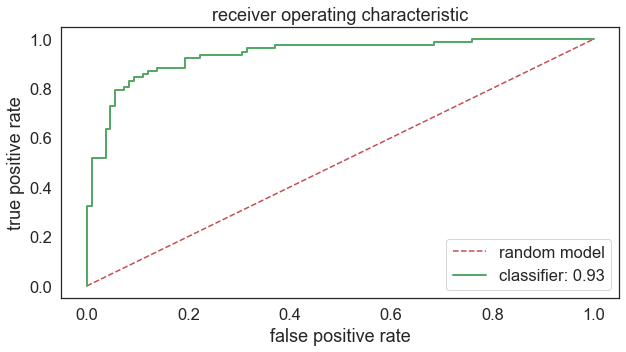



confussion matrix:



,1,0
1,67,13
0,10,95




Accuracy:                                                                   ................0.88
Precision (tp / (tp + fp)):                                                 ................0.84
Recall (tp / (tp + fn)):                                                    ................0.87
F1 ((2 * (precision * recall)) / (precision + recall)):                     ................0.85
False Positive Rate (fp / (fp + tn))                                        ................0.12
True Positive Rate ((tp / (tp + fn)):                                       ................0.87
Increase in TPR / FPR (true_positive_rate / false_positive_rate):           ................7.25




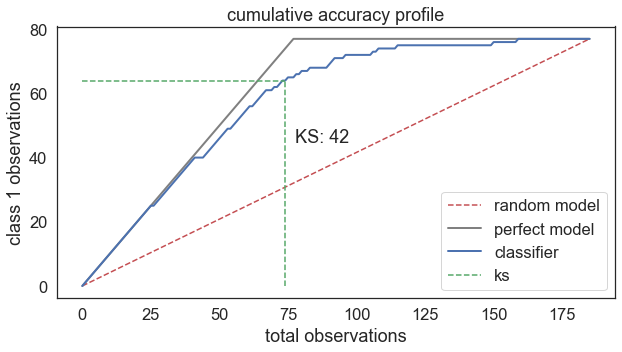

,bin,count_of_rows,missed_playoffs,model_percent,random_percent,model_cumm_percent,random_cumm_percent,ks
0,0.0,0,0,0.00,0,0.00,0,0.00
1,1.0,18,18,23.38,10,23.38,10,13.38
2,2.0,18,17,22.08,10,45.46,20,25.46
3,3.0,18,14,18.18,10,63.64,30,33.64
4,4.0,18,14,18.18,10,81.82,40,41.82
5,5.0,18,6,7.79,10,89.61,50,39.61
6,6.0,18,5,6.49,10,96.10,60,36.10
7,7.0,18,1,1.30,10,97.40,70,27.40
8,8.0,18,0,0.00,10,97.40,80,17.40
9,9.0,18,2,2.60,10,100.00,90,10.00


,bin,min_predicted_proba_per_bin,max_predicted_proba_per_bin,mean_predicted_proba_per_bin,median_predicted_proba_per_bin
0,1.0,0.967566,0.999657,0.987463,0.989133
1,2.0,0.873670,0.966869,0.916868,0.914645
2,3.0,0.741952,0.858804,0.802031,0.809719
3,4.0,0.440495,0.721537,0.544718,0.547067
4,5.0,0.286834,0.433693,0.363192,0.353108
5,6.0,0.210882,0.286834,0.243951,0.242245
6,7.0,0.120190,0.208195,0.166677,0.168653
7,8.0,0.052741,0.116091,0.078404,0.070324
8,9.0,0.017197,0.050881,0.033498,0.032666
9,10.0,0.000008,0.017060,0.005455,0.004589


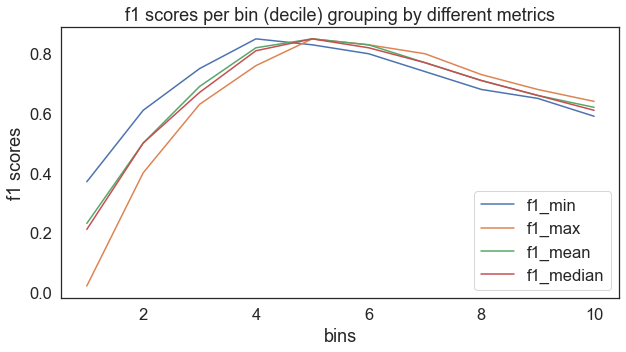

,bin,threshold_min,f1_min,threshold_max,f1_max,threshold_mean,f1_mean,theshold_median,f1_median
0,1.0,0.967566,0.37,0.999657,0.02,0.987463,0.23,0.989133,0.21
1,2.0,0.873670,0.61,0.966869,0.40,0.916868,0.50,0.914645,0.50
2,3.0,0.741952,0.75,0.858804,0.63,0.802031,0.69,0.809719,0.67
3,4.0,0.440495,0.85,0.721537,0.76,0.544718,0.82,0.547067,0.81
4,5.0,0.286834,0.83,0.433693,0.85,0.363192,0.85,0.353108,0.85
5,6.0,0.210882,0.80,0.286834,0.83,0.243951,0.83,0.242245,0.82
6,7.0,0.120190,0.74,0.208195,0.80,0.166677,0.77,0.168653,0.77
7,8.0,0.052741,0.68,0.116091,0.73,0.078404,0.71,0.070324,0.71
8,9.0,0.017197,0.65,0.050881,0.68,0.033498,0.66,0.032666,0.66
9,10.0,0.000008,0.59,0.017060,0.64,0.005455,0.62,0.004589,0.61


In [15]:
# Test results
test_cap_auc = cap_auc(
    model = logit_regressor, 
    df = results, 
    target = 'missed_playoffs', 
    y = playoff_flag, 
    y_pred = results[['predictions_test']],
    y_score = proba, 
    X = X_test,
    length = 5, 
    width = 10, 
    ks = 40, 
    text = 'KS: 42',
    font = 1.5
)

display(test_cap_auc)
print('\n')

# Bootstrap f1 results
boostrap_f1(
    cap_threshold_df = test_cap_auc,
    x_axis = 'bin',
    results_df = results, 
    real_results_col = 'missed_playoffs', 
    pred_col = 'predictions_test', 
    pred_proba_col = 'predicted_proba',
    length = 5,
    width = 10,
    font = 1.5
)

The model shows strong results on the test data. The results are slightly lower, however, this is to be expected on the test data.

Notable observations:

1) **Concordance** - 0.93 <br>

2) **Area Under the Curve (AUC)** - 0.93<br>

3) **F1** - 0.84<br>

4) **Kolmogorov-Smirnov Measure (ks)** - 42% at the 4th decile, a cumulative percentage 2.05 (82% (model) / 40% (random model)) times greater than a random model.<br>

### Model Finalization

In [16]:
# Set X values
X = nhl_df[['aboveAvgAdjWins']]

# Set y values
y = nhl_df[['missed_playoffs']]

# Print data results
print(X.info())
display(X.head())
print(y.info())
display(y.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   aboveAvgAdjWins  922 non-null    float64
dtypes: float64(1)
memory usage: 7.3 KB
None


,aboveAvgAdjWins
0,-19.470588
1,12.029412
2,6.529412
3,9.029412
4,-20.970588


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   missed_playoffs  922 non-null    int64
dtypes: int64(1)
memory usage: 7.3 KB
None


,missed_playoffs
0,1
1,0
2,0
3,0
4,1


Create an X and y data frame for the entire data set.

In [17]:
# Fit and train the logistic regression model
logit_regressor = LogisticRegression(
    penalty = grid.best_params_.get('penalty'),
    C = grid.best_params_.get('C'),
    solver = grid.best_params_.get('solver')
)

# Scale X values (converts X values to numpy 2D array)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# Convert y values to numpy 1D array
y = y.iloc[:,:].values
y = y.reshape((-1,))

# Fit classifier
logit_regressor.fit(X, y)

LogisticRegression(C=10.0, penalty='l1', solver='liblinear')

Train model on entire data set to finalize the model.

In [18]:
# save the model
dump(logit_regressor, open('Classification_Models/NHL_Playoffs_Logistic_Regression_Model.pkl', 'wb'))

# save the scaler
dump(scaler, open('Classification_Models/Scaler_Logi.pkl', 'wb'))

Save logistic regression model.

In [19]:
# load the model
model = load(open('Classification_Models/NHL_Playoffs_Logistic_Regression_Model.pkl', 'rb'))

# load the scaler
scaler = load(open('Classification_Models/Scaler_Logi.pkl', 'rb'))

Load logistic regression model.

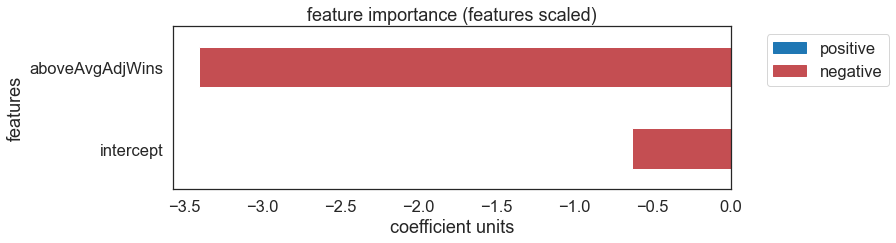

,features,coef,positive
1,aboveAvgAdjWins,-3.403598,False
0,intercept,-0.635154,False


In [20]:
# Convert X back to a data frame
X = pd.DataFrame(X, columns = ['aboveAvgAdjWins'])

classification_feature_importance(
    model = model, 
    X_cols = X, 
    font = 1.5, 
    length = 3, 
    width = 10, 
    pos = 'b', 
    neg = 'r'
)

### Summary

aboveAvgAdjWins has proven to be an effective feature when predicting playoff contention for NHL organizations.

If teams want to make the playoffs they need to increase their aboveAvgAdjWins. To increase their aboveAvgAdjWins, teams must seek to focus on:

1) **save_pctg**
* Feature importance:
* Coef: 6.44<br>

2) **shooting_pctg**
* Feature importance
* Coef: 6.34<br>

3) **saves_per_game**
* Feature importance:
* Coef: -3.39<br>

4) **failed_shots_per_game**
* Feature importance:
* Coef: 2.84<br>

5) **penalty_kill_percentage**
* Feature importance:
* Coef: 0.27<br>

Features are in descending order basis importance.<br>
Features that are positive values, teams should look to increase them.<br>
Features with negative values, teams should look to decrease them.